# Demonstration of the semi-lagrangian advection code for the potential temperature at the tropopause. 

Basic libraries:

In [1]:
import numpy as np
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
from netCDF4 import Dataset

A few libraries are needed to handle paths smoothly in Python with Windows:

In [2]:
from pathlib import Path
import os
import inspect
# Path to 
self_path = Path(os.path.dirname(inspect.getfile(lambda: None)))

# create_netcdf

The function create_netcdf creates a "application neutral" netCDF file. It does not intialize the value of the array, it just create the dimensions, attributes, variables, etc. It handles the part of the initialization that would be common to all test cases. It returns the handle to the dataset (i.e. the netCDF file) for further modifications. It creates the variables:

- "theta\_t", which stands for $\theta_t$ the potential temperature at the tropopause,
- "u\_t", which stands for $u_t$ the zonal component of the wind at the tropopause,
- "v\_t", which stands for $v_t$ the meridional component of the wind at the tropopause,
- "alpha\_u" which stands for $\alpha\_u$ the zonal estimation of the displacement (this quanitity is specific to the semi-Lagrangian scheme)
- "alpha\_v" which stands for $\alpha\_v$ the meriodnal estimation of the displacement (this quanitity is specific to the semi-Lagrangian scheme)
- "t" will store the time at each iteration
- "x\_grid" is an array of the same shape as the model grid, storing the zonal position of each grid point,
- "y\_grid" is an array of the same shape as the model grid, storing the meridional position of each grid point.

In [3]:
def create_netcdf(path, Lx, Ly, T, Nx, Ny, Nt):

#CREATION OF THE NETCDF FILE --------------------------------------------------

    file_path= self_path / path
    handle = Dataset(file_path, 'w',format='NETCDF4')

#------------------------------------------------------------------------------

#DIMENSIONS -------------------------------------------------------------------

    handle.createDimension("Nx", Nx)
    handle.createDimension("Ny", Ny)
    handle.createDimension("Nt", None) 

#------------------------------------------------------------------------------

#ATTRIBUTE --------------------------------------------------------------------
    handle.T = T    
    handle.Lx = Lx
    handle.Ly = Ly
    handle.Nx = Nx
    handle.Ny = Ny
    handle.Nt = Nt
    handle.dx = Lx / Nx
    handle.dy = Ly/ Ny  
    handle.dt = T/Nt
#------------------------------------------------------------------------------

#VARIABLES --------------------------------------------------------------------
    # "f8" is a data type: 64-bit floating point variable
    handle.createVariable("ut","f8", ("Nx", "Ny", "Nt"))
    handle.createVariable("vt", "f8", ("Nx", "Ny", "Nt"))
    handle.createVariable("theta_t", "f8",("Nx", "Ny", "Nt"))
    handle.createVariable("alpha_u", "f8", ("Nx", "Ny", "Nt"))
    handle.createVariable("alpha_v", "f8", ("Nx", "Ny", "Nt"))
    handle.createVariable("t", "f8", ("Nt"))
    handle.createVariable("x_grid", "f8", ("Nx", "Ny"))
    handle.createVariable("y_grid", "f8", ("Nx", "Ny"))
#------------------------------------------------------------------------------

#GEOMETRY INITIALIZATION ------------------------------------------------------
    
    grid = np.mgrid[0:handle.Lx:handle.dx, 0:handle.Ly:handle.dy]
    handle['x_grid'][:,:] = grid[0,:,:]
    handle['y_grid'][:,:] = grid[1,:,:]

#------------------------------------------------------------------------------
    return(handle)
 

# test_cases.py

Creating the netcdf is not enough, we also need to define initial conditions. A simple way to do that is to create one function per test case, wich calls create_netcdf and then initialize:
- $\theta_t$ at time $t_{-1}$,
- $\theta_t$ at time $t_{0}$,
- $u_t$ at time $t_0$,
- $v_t$ at time $t_0$,
- $\alpha_u$ at time $t_{0}$,
- $\alpha_v$ at time $t_{0}$.

For the moment, three functions are available in test_cases.py:
- bubble_test initializes a test case with a potential temperature field equal to 0 everywhere but in a bubble where its value is 1. 
- gaussian_test initializes a test case with a potential temperature field equal to 0 everywhere but in a rectangle smoothed with a gaussian filter for a more 'continuous' input
- v_stripe_test is meant to be similar to the initial conditions in Wirth et al. The temperature is equal to 300K except in a finite horizontal stripe. The cross section of the stripe is a V-shaped profile where the temperature is lower (at its minimum it has a temperature of 285K). 
For each of these function this field is used both for $t_{-1}$ and $t_0$. To stay consistent with this choice, the initial displacement estimates are chosen equal to zero. The dimensions of the domain and time information are also taken as arguments and transferred to creat_netcdf.

In [4]:
def v_stripe_test(path, Lx, Ly, Nx, Ny, T, Nt, dX, dY):
    
    handle = create_netcdf(path, Lx, Ly,T,  Nx, Ny, Nt)
#ATTRIBUTES -------------------------------------------------------------------

    handle.T = T
    handle.dt = T/Nt
    handle.Nt = Nt
#------------------------------------------------------------------------------

#INITIALIZATION ---------------------------------------------------------------
        
    #Bubble creation
    [X,Y] = np.mgrid[0:Nx,0:Ny]
    F = 300*np.ones((Nx, Ny))
    depth = -15
    


    F[dX : Nx-dX, Ny//2 - dY : Ny//2 + dY] = \
        F[dX : Nx-dX, Ny//2 - dY : Ny//2 + dY] +\
        (np.abs(Y[dX : Nx-dX, Ny//2 - dY : Ny//2 + dY] - Ny//2)/dY -1)*depth
    
    left_ind= np.where(np.logical_and(\
                    (X - dX)**2 + (Y - Ny//2)**2 < (dY)**2,
                    X < dX ))
    F[left_ind] = F[left_ind] +\
             (np.sqrt((Y[left_ind]-Ny//2)**2 + (X[left_ind]-dX)**2 ) \
             /dY -1)*depth
                 
    right_ind= np.where(np.logical_and(\
                    (X - (Nx - dX - 1))**2 + (Y - Ny//2)**2 < dY**2,
                    X > (Nx - dX - 1) ))
    F[right_ind] = F[right_ind] +\
             (np.sqrt((Y[right_ind]-Ny//2)**2 + \
                      (X[right_ind]-(Nx-dX-1))**2 )/dY -1)*depth
                 

    
    
    #Potential temperature
    handle['theta_t'][:,:,0] = F
    handle['theta_t'][:,:,1] = F
    
    #Initial displacement guess for advection
    handle['alpha_u'][:,:,0] = np.zeros((Nx,Ny))
    handle['alpha_v'][:,:,0] = np.zeros((Nx,Ny))
    
    #Uniform wind
    handle['ut'][:,:,0] = np.zeros((Nx,Ny))
    handle['vt'][:,:,0] = np.zeros((Nx,Ny))
    
    #time storage
    handle['t'][0] = 0
    handle['t'][1] = handle.dt
#------------------------------------------------------------------------------
    
    handle.close()
    
#------------------------------------------------------------------------------



def bubble_test(path, Lx, Ly, Nx, Ny, T, Nt, cx, cy, radius):
    
    handle = create_netcdf(path, Lx, Ly,T,  Nx, Ny, Nt)
#ATTRIBUTES -------------------------------------------------------------------

    handle.T = T
    handle.dt = T/Nt
    handle.Nt = Nt
#------------------------------------------------------------------------------

#INITIALIZATION ---------------------------------------------------------------
        
    #Bubble creation
    bubble_indices = np.where ( np.abs(handle['x_grid'][:,:] - cx) + \
                               np.abs(handle['y_grid'][:,:] - cy) < radius )
    F = np.zeros((Nx, Ny))
    F[bubble_indices] = 1
    
    #Potential temperature
    handle['theta_t'][:,:,0] = F
    handle['theta_t'][:,:,1] = F
    
    #Initial displacement guess for advection
    handle['alpha_u'][:,:,0] = np.zeros((Nx,Ny))
    handle['alpha_v'][:,:,0] = np.zeros((Nx,Ny))
    
    #Uniform wind
    handle['ut'][:,:,0] = np.zeros((Nx,Ny))
    handle['vt'][:,:,0] = np.zeros((Nx,Ny))
    
    #time storage
    handle['t'][0] = 0
    handle['t'][1] = handle.dt
#------------------------------------------------------------------------------
    
    handle.close()
    
#-------------------------------------------------------------------------


def gaussian_test(path, Lx, Ly, Nx, Ny, T, Nt):
    
    handle = create_netcdf(path, Lx, Ly,T,  Nx, Ny, Nt)
#ATTRIBUTES -------------------------------------------------------------------

    handle.T = T
    handle.dt = T/Nt
    handle.Nt = Nt
#------------------------------------------------------------------------------

#INITIALIZATION ---------------------------------------------------------------
        
    #Filament creation
    thetatp = np.zeros((Nx,Ny))
    import scipy.ndimage as spnd 
    Px = 8 
    Py = 64
    thetaanom = 15
    for i in range(Nx): 
        for j in range(Ny):
            if abs(i-Nx/2) < Py and abs(j-Ny/2) < Px:
                thetatp[i,j] = thetaanom
    spnd.gaussian_filter(thetatp, 10, output=thetatp)
    
    #Potential temperature
    handle['theta_t'][:,:,0] = thetatp
    handle['theta_t'][:,:,1] = thetatp
    
    #Initial displacement guess for advection
    handle['alpha_u'][:,:,0] = np.zeros((Nx,Ny))
    handle['alpha_v'][:,:,0] = np.zeros((Nx,Ny))
    
    #Uniform wind
    handle['ut'][:,:,0] = np.zeros((Nx,Ny))
    handle['vt'][:,:,0] = np.zeros((Nx,Ny))
    
    #time storage
    handle['t'][0] = 0
    handle['t'][1] = handle.dt
#------------------------------------------------------------------------------
    
    handle.close()
    
#------------------------------------------------------------------------------

# upstream_interp.py

In the semi-Lagrangian scheme, we often need to interpolate a field 'upstream'. The first input is the value of the field $F$ (wich can be multidimensional) on a grid. Let $x$, $y$ denote the zonal and meridional coordinates of a grid point.
For each grid point, we have an estimation of the displacement of the particle on both axis: $\alpha_x$ and $\alpha_y$. We need to interpolate the value of $F$ at each location $(x-\alpha_x,\; y-\alpha_y)$: this forms an unstrcutred mesh, which makes it impossible to use interpolate_2d from the scipy library. The griddata function can have an unstructured mesh as an output but is also assumes an unstructured input. As we have a structured input we want to use that assumption for an effective implementation. Moreover, it does not include any type of boundary conditions, while we need to use periodic boundary conditions. Consequently, we need a custom function to do that job. We need both linear and bicubic interpolation (only linear is available now).

In [5]:
def upstream_interp(alpha_x, alpha_y, F, method='linear'):
    
    if len(F.shape)==2:
        F = np.array([F])
        
    [dim,Nx,Ny] = F.shape
    F_int = np.zeros((dim,Nx,Ny))
    if method=='nearest':
         # Coordinates of the points of the upstream mesh
         [x_grid, y_grid] = np.mgrid[0:Nx-1, 0:Ny-1]
         x_grid = x_grid -alpha_x
         y_grid = y_grid- alpha_y
         
         # Apply periodic boundary coniditions. Note that nothing is done
         # for x,y<0 as the indices are already periodic in Python. 
         x_grid[np.where(x_grid > Nx-1)] -= (Nx-1)
         y_grid[np.where(y_grid > Ny-1)] -= (Ny-1)
         
         # Fetch the closest neighbor
         F_int[:,:,:] = F[np.round(x_grid), np.round(y_grid),:]
         
    elif method=='linear':
        #We loop on the elements of alpha_u/v
        for x in range(Nx):
            for y in range(Ny):
                #Upstream coordinates
                xi = x - alpha_x[x,y]
                yi = y - alpha_y[x,y]
                
                # Periodic boundary conditions
                #print("xi,yi : ", xi,yi)
                if (xi > 2*(Nx-1) or x< -Nx-1 
                    or yi > 2*(Ny-1) or yi< -Ny-1): 
                    print('Displacement is too large: alpha = [',\
                          alpha_x[x,y],", ", alpha_y[x,y],"] grid points")
                
                if xi<0 :
                    xi += Nx-1 
                elif xi> Nx-1:
                    xi -= (Nx-1)
                if xi<0 :
                    yi += Ny-1
                elif yi> Ny-1:
                    yi -= (Ny-1)
                
                
                #Coordinates of the top right corner, and distance   
                x_top = int(np.ceil(xi))
                y_top = int(np.ceil(yi))
                
                
                x_coeff = x_top - xi
                y_coeff = y_top - yi
                
                #Update of F_int
                F_int[:,x,y] = x_coeff * y_coeff * F[:,x_top-1,y_top-1] \
                    + x_coeff * (1-y_coeff) * F[:,x_top-1,y_top] \
                    + (1-x_coeff) * (1-y_coeff) * F[:,x_top,y_top] \
                    + (1-x_coeff) * y_coeff * F[:,x_top,y_top-1] 
                    
    elif method=='bicubic':
        # For a given point, bi-cubic interpolation fits the value of the 
        # four surrounding points as well as the slope at each of these 
        # points. The slope is evaluated using centered finite differences.
        # We can reduce this operation to a weight for each of the sixteen
        # surrounding points. We compute these weights for each grid cell.
        # Each of the 16 is thus stored in an array. A halo is added to 
        # the grid to handle boundary conditions.
        
        #Boundary conditions ---------------------------------------------
        F_halo=np.zeros((dim,Nx + 4, Ny + 4))
        F_halo[:, 2:-2, 2:-2] = F # Center
        
        F_halo[:, :2, 2:-2]  = F[:, -2:, :]#West band
        F_halo[:, -2:, 2:-2] = F[:, :2, :]#East band
        F_halo[:, 2:-2, :2]  = F[:, :, -2:]#South band
        F_halo[:, 2:-2, -2:] = F[:, :, :2]#North band
        
        F_halo[:, :2, :2] = F[:, -2:, -2:] #South-West corner
        F_halo[:, -2:, :2] = F[:, :2, -2:] #South-East corner
        F_halo[:, -2:, -2:] = F[:, :2, :2] #North-East corner
        F_halo[:, :2, -2:] = F[:, -2:, :2] #NOrth-West corner
        
        
        # Computation of the weights -------------------------------------
        a00 = F_halo[:, 1:-2, 1:-2]
        
        a01 = -0.5 * F_halo[:, 1:-2, 0:-3] + 0.5 * F_halo[:, 1:-2, 2:-1]
        
        a02 = F_halo[:, 1:-2, 0:-3] - 2.5 * F_halo[:, 1:-2, 1:-2] + \
            2 * F_halo[:, 1:-2, 2:-1] -  0.5 * F_halo[:, 1:-2, 3:]
            
        a03 = -.5 * F_halo[:, 1:-2, 0:-3] + 1.5 * F_halo[:, 1:-2, 1:-2] - \
            1.5 * F_halo[:, 1:-2, 2:-1] + 0.5 * F_halo[:, 1:-2, 3:]
            
        a10 = -.5 * F_halo[:, 0:-3, 1:-2] + 0.5 * F_halo[:, 2:-1, 1:-2]
        
        a11 = 0.25 * F_halo[:, 0:-3, 0:-3] - 0.25 * F_halo[:, 0:-3, 2:-1] - \
            0.25 * F_halo[:, 2:-1, 0:-3] + 0.25 * F_halo[:, 2:-1, 2:-1]
            
        a12 = -.5 * F_halo[:, 0:-3, 0:-3] + 1.25 * F_halo[:, 0:-3, 1:-2] - \
            F_halo[:, 0:-3, 2:-1] +  0.25 * F_halo[:, 0:-3, 3:] + \
                0.5 * F_halo[:, 2:-1, 0:-3] - 1.25 * F_halo[:, 2:-1, 1:-2] + \
                    F_halo[:, 2:-1, 2:-1] - 0.25 * F_halo[:, 2:-1, 3:]
                    
        a13 = 0.25 * F_halo[:, 0:-3, 0:-3] - 0.75 * F_halo[:, 0:-3, 1:-2] + \
            0.75 * F_halo[:, 0:-3, 2:-1] -  \
            0.25 * F_halo[:, 0:-3, 3:] - \
            0.25 * F_halo[:, 2:-1, 0:-3] + 0.75 * F_halo[:, 2:-1, 1:-2] - \
            0.75 * F_halo[:, 2:-1, 2:-1] + 0.25 * F_halo[:, 2:-1, 3:]
                
        a20 = F_halo[:, 0:-3, 1:-2] - 2.5 * F_halo[:, 1:-2, 1:-2] + \
            2 * F_halo[:, 2:-1, 1:-2] -  0.5 * F_halo[:, 3:, 1:-2]
            
        a21 = -.5 * F_halo[:, 0:-3, 0:-3] + 0.5 * F_halo[:, 0:-3, 2:-1] + \
            1.25 * F_halo[:, 1:-2, 0:-3] -  \
            1.25 * F_halo[:, 1:-2, 2:-1] - F_halo[:, 2:-1, 0:-3] + \
                F_halo[:, 2:-1, 2:-1] + 0.25 * F_halo[:, 3:, 0:-3] -  \
                    0.25 * F_halo[:, 3:, 2:-1]
                    
        a22 = F_halo[:, 0:-3, 0:-3] - 2.5 * F_halo[:, 0:-3, 1:-2] + \
            2 * F_halo[:, 0:-3, 2:-1] -  \
            0.5 * F_halo[:, 0:-3, 3:] - 2.5 * F_halo[:, 1:-2, 0:-3] + \
                6.25 * F_halo[:, 1:-2, 1:-2] - 5 * F_halo[:, 1:-2, 2:-1] + \
                1.25 * F_halo[:, 1:-2, 3:] + 2 * F_halo[:, 2:-1, 0:-3] \
                - 5 * F_halo[:, 2:-1, 1:-2] + 4 * F_halo[:, 2:-1, 2:-1] - \
                    F_halo[:, 2:-1, 3:] - 0.5 * F_halo[:, 3:, 0:-3] + \
                        1.25 * F_halo[:, 3:, 1:-2]  - F_halo[:, 3:, 2:-1] + \
                            0.25 * F_halo[:, 3:, 3:]
                            
        a23 = -.5 * F_halo[:, 0:-3, 0:-3] + 1.5 * F_halo[:, 0:-3, 1:-2] - \
            1.5 * F_halo[:, 0:-3, 2:-1] +  0.5 * F_halo[:, 0:-3, 3:] + \
            1.25 * F_halo[:, 1:-2, 0:-3] - 3.75 * F_halo[:, 1:-2, 1:-2] + \
                3.75 * F_halo[:, 1:-2, 2:-1] -  1.25 * F_halo[:, 1:-2, 3:] - \
                F_halo[:, 2:-1, 0:-3] + 3 * F_halo[:, 2:-1, 1:-2] - \
                    3 * F_halo[:, 2:-1, 2:-1] +  F_halo[:, 2:-1, 3:] + \
                        0.25 * F_halo[:, 3:, 0:-3] - \
                            0.75 * F_halo[:, 3:, 1:-2] +  \
                                0.75 * F_halo[:, 3:, 2:-1] - \
                                    0.25 * F_halo[:, 3:, 3:]
                    
        a30 = -.5 * F_halo[:, 0:-3, 1:-2] + 1.5 * F_halo[:, 1:-2, 1:-2] - \
            1.5 * F_halo[:, 2:-1, 1:-2] + 0.5 * F_halo[:, 3:, 1:-2]
            
        a31 = 0.25 * F_halo[:, 0:-3, 0:-3] - 0.25 * F_halo[:, 0:-3, 2:-1] - \
            0.75 * F_halo[:, 1:-2, 0:-3] + 0.75 * F_halo[:, 1:-2, 2:-1] + \
                0.75 * F_halo[:, 2:-1, 0:-3] - 0.75 * F_halo[:, 2:-1, 2:-1] - \
                    0.25 * F_halo[:, 3:, 0:-3] + 0.25 * F_halo[:, 3:, 2:-1];
        
        a32 = -.5 * F_halo[:, 0:-3, 0:-3] + 1.25 * F_halo[:, 0:-3, 1:-2] - \
            F_halo[:, 0:-3, 2:-1] + 0.25 * F_halo[:, 0:-3, 3:] + \
                1.5 * F_halo[:, 1:-2, 0:-3] - 3.75 * F_halo[:, 1:-2, 1:-2] + \
                    3 * F_halo[:, 1:-2, 2:-1] - 0.75 * F_halo[:, 1:-2, 3:] - \
                        1.5 * F_halo[:, 2:-1, 0:-3] + \
                            3.75 * F_halo[:, 2:-1, 1:-2] - \
                                3 * F_halo[:, 2:-1, 2:-1] +\
                                    0.75 * F_halo[:, 2:-1, 3:] + \
                                        0.5 * F_halo[:, 3:, 0:-3] - \
                                            1.25 * F_halo[:, 3:, 1:-2] + \
                                                F_halo[:, 3:, 2:-1] - \
                                                    0.25 * F_halo[:, 3:, 3:]
		
        a33 = 0.25 * F_halo[:, 0:-3, 0:-3] - 0.75 * F_halo[:, 0:-3, 1:-2] + \
            0.75 * F_halo[:, 0:-3, 2:-1] - 0.25 * F_halo[:, 0:-3, 3:] -  \
            0.75 * F_halo[:, 1:-2, 0:-3] + 2.25 * F_halo[:, 1:-2, 1:-2] - \
                2.25 * F_halo[:, 1:-2, 2:-1] + 0.75 * F_halo[:, 1:-2, 3:] + \
                0.75 * F_halo[:, 2:-1, 0:-3] - 2.25 * F_halo[:, 2:-1, 1:-2] +\
                    2.25 * F_halo[:, 2:-1, 2:-1] - 0.75 * F_halo[:, 2:-1, 3:]\
                        - 0.25 * F_halo[:, 3:, 0:-3] + \
                            0.75 * F_halo[:, 3:, 1:-2] - \
                                0.75 * F_halo[:, 3:, 2:-1] + \
                                    0.25 * F_halo[:, 3:, 3:]
    
    # Loop through the mesh points
        for x in range(Nx):
            for y in range(Ny):
                #Upstream coordinates
                xi = x - alpha_x[x,y]
                yi = y - alpha_y[x,y]
                                
                # Periodic boundary conditions
                #print("xi,yi : ", xi,yi)
                if (xi > 2*(Nx-1) or yi > 2*(Ny-1)):
                    print('Displacement too large: xi,yi=',xi,yi)
                
                if xi<0 :
                    xi += Nx-1 
                elif xi> Nx-1:
                    xi -= (Nx-1)
                if xi<0 :
                    yi += Ny-1
                elif yi> Ny-1:
                    yi -= (Ny-1)
                
                #Normalized coordinates inside the cell
                xb = xi - np.floor(xi)
                yb = yi - np.floor(yi)
                
                #Indice of the weights corresponding to the cell
                xf = int(np.floor(xi))+1
                yf = int(np.floor(yi))+1
                
                #Update of F
                F_int[:, x, y] = \
                    (a00[:, xf, yf] + a01[:, xf, yf] * yb +\
                     a02[:, xf, yf] * yb**2 + a03[:, xf, yf] * yb**3) +\
                    (a10[:, xf, yf] + a11[:, xf, yf] * yb +\
                     a12[:, xf, yf] * yb**2 + a13[:, xf, yf] * yb**3) * xb +\
                    (a20[:, xf, yf] + a21[:, xf, yf] * yb +\
                     a22[:, xf, yf] * yb**2 + a23[:, xf, yf] * yb**3) * xb**2 +\
                    (a30[:, xf, yf] + a31[:, xf, yf] * yb +\
                     a32[:, xf, yf] * yb**2 + a33[:, xf, yf] * yb**3) * xb**3 
    else:
        print('Unkwon method for interpolation: ',method)
    if dim==1:
        F_int = F_int[0,:,:]
    
    return F_int

#  advection_step_3P.py

The first advection shceme considered is a semi-Lagrangain scheme which requires evaluations of the advected field at three points in time. At the iteration k, the inputs of the advection scheme are:

- $F^{-}$, the advected field at time $t_k - d_t$ for all grid points
- $\alpha^{-}_u$ the estimated zonal displacement at time $t_k - d_t$ for all grid points
- $\alpha^{-}_v$the estimated meridional displacement at time $t_k - d_t$ for all grid points
- $u$ the zonal component of the wind at time $t_k$
- $v$ the meridional componenet of the wind at time $t_k$
- $d_t$ the time step of the numerical scheme
- the zonal and meridional coordinates $x,y$ of all grid points 

Its outputs are:
- $F^{+}$, the advected field at time $t_k + d_t$ for all grid points
- $\alpha_u$,  the estimated zonal displacement at time $t_k$ for all grid points
- $\alpha_v$the estimated meridional displacement at time $t_k$ for all grid points


The estimate of the displacement at time t_k is approximately the solution of:
\begin{align}
\alpha_u &= \Delta_t u [(x-\alpha_u, y-\alpha_v)_,t_k],\\
\alpha_v &= \Delta_t v [(x-\alpha_u, y-\alpha_v)_,t_k].
\end{align}
It can be approached through an iterative scheme (fixed point) initialized by the estimate of the displacement at time $t_{k1}$, i.e. $\alpha_u^{-}, \alpha_v^{-}$.

Note that $F$ the advected field at time $t_k$, does not actually appear in the calculations at iteration $k$, but at the previous and next one. One step of the advection scheme consists in:

- Approach iteratively $\alpha_u, \alpha_v$. These locations represents the estimated location of the particles which should end up in $x, y$ after one time step.
- use the interpolated winds to update the estimations of the displacement:
\begin{align}
\alpha_u(x,y) &= d_t \times u(x - \alpha_u^{-}, y - \alpha_v^{-}),\\
\alpha_v(x,y) &= d_t \times v(x - \alpha_u^{-}, y - \alpha_v^{-}).
\end{align}
- Interpolate the advected field at time $t_k-d_t$ at the locations $(x - 2*\alpha_u^{-}, y - 2*\alpha_v^{-})$. This represents the estimated locations of the particles which will end up in $x,y$ at times $t_k+d_t$:
\begin{equation}
F^{+}(x,y) = F^{-}(x - 2*\alpha_u^{-}, y - 2*\alpha_v^{-}).
\end{equation}

In [6]:
def advection_step_3P(alpha_u_minus, alpha_v_minus,field_minus, dt, u, v,
                      dx, dy, alpha_method='linear',
                      order_alpha=2, F_method='bicubic'):
    
# ITERATIVE ESTIMATION OF THE DISPLACEMENT-------------------------------
# The displacement alpha is estimated iteratively by interpolating the wind 
# in x -alpha_minus, where alpha is the previous estimate. At each time
# step, a number of iterations order_alpha is used, and the iterative 
# scheme is initialized with the estimate at the previous time step.
    for k in range (order_alpha):
        # Staniforth et Al. states that for the interpolation of the 
        # estimated displacement, linear interpolation is usually 
        # sufficient. Cubic interpolation is more accurate but more 
        # expensive. An interesting compromise is to use the option 'mix',
        # which uses linear inteprolation for all iterations but the last
        # one, for which cubic interpolation is used.
        if k==order_alpha-1 and alpha_method =='mix':
            method = 'bicubic'
        elif k < order_alpha-1 and alpha_method =='mix':
            method='linear'
        else:
            method=alpha_method
            
        [alpha_u, alpha_v] = (dt/dx)*upstream_interp(alpha_u_minus,
                                        alpha_v_minus,
                                        np.array([u,v]),method=method)
        alpha_u_minus = alpha_u
        alpha_v_minus = alpha_v
        
#------------------------------------------------------------------------
    
    # The field at time tk + dt is udpated by interpolating the field at 
    # time tk -dt at the locations x - 2* alpha.
    field_plus = upstream_interp(2*alpha_u, 2*alpha_v, field_minus,
                                 method = F_method)

    return alpha_u, alpha_v, field_plus
    


In order to test this function, we need a driver which iterates and handles all the variable updates. Most of the options can be fetched from the netCDF. For the moment a boolean pseudo\_spectral\_wind is available as another option. If equal to 0, the wind is kept constant throughout iterations. If equal to 1, the pseudo spectral balance relations are used to update it at each iteration. The code unpacks data from the netCDF and starts iterating. At each iteration, the following operations are realized:

- update the wind. It can be done using the potential temperature by calling the pseudo-spectral balance relations
- advect the potential temperature using the updated wind. 
- save the variables which are not needed anymore in the netCDF file 
- Update the variables: $F \rightarrow F^{-}$, $F^{+} \rightarrow F$, etc. 


In [7]:
# -*- coding: utf-8 -*-
"""
Created on Wed Dec  9 11:31:54 2020

@author: 33676
"""

import time
from netCDF4 import Dataset
# My cocktail to make path stuff work in Python


from test_cases import bubble_test, gaussian_test, v_stripe_test
from advection_step_3P import advection_step_3P 
from spectral import streamfunc, geostwind




def advection_driver(path, pseudo_spectral_wind=1, 
                     alpha_method = 'mix', F_method='bicubic'):
    
    #UNPACK DATA ------------------------------------------------
    handle = Dataset(path, 'r+',format='NETCDF4')  
    Nt = handle.Nt
    dt = handle.dt
    Lx = handle.Lx
    Ly = handle.Ly
    Nx = handle.Nx
    Ny = handle.Ny
    dx=handle.dx
    dy=handle.dx
    ut_minus = handle['ut'][:,:,0]  
    vt_minus = handle['vt'][:,:,0]
    x_grid = handle['x_grid'][:,:]
    y_grid = handle['y_grid'][:,:]
    alpha_u_minus = handle['alpha_u'][:,:,0]
    alpha_v_minus = handle['alpha_v'][:,:,0]
    theta_minus = handle['theta_t'][:,:,0]
    theta = handle['theta_t'][:,:,1]
    t0 = time.time()
    for k in range (1, Nt):
        print("Progress: ",round(100*k/Nt,2)," %")
        
        # UPDATE OF THE TROPOPAUSE WIND---------------------------------
        if (pseudo_spectral_wind == True):
            psi = streamfunc(Lx, Ly, Nx, Ny, theta)
            vt,ut = geostwind(Lx, Ly, Nx, Ny, psi)
           
        else:
            ut = ut_minus
            vt = vt_minus 
        #---------------------------------------------------------------
                
        
        #ADVECTION AT THE TROPOPAUSE------------------------------------
        alpha_u, alpha_v, theta_plus = \
        advection_step_3P(alpha_u_minus, alpha_v_minus,theta_minus,
                          dt, ut, vt, dx, dy, alpha_method = alpha_method,
                          F_method=F_method)
        #---------------------------------------------------------------
        
        
        
        
        # Write new quantities to netCDF
        handle['alpha_u'][:,:,k] = alpha_u
        handle['alpha_v'][:,:,k] = alpha_v
        handle['theta_t'][:,:,k+1] = theta_plus 
        handle['ut'][:,:,k] = ut
        handle['vt'][:,:,k] = vt
        handle['t'][k+1] = handle ['t'][k] + dt 
        
        # Update temporary arays
        alpha_u_minus = alpha_u
        alpha_v_minus = alpha_v
        theta_minus = theta
        theta = theta_plus
        ut_minus = ut
        vt_minus = vt
    cpu_time = time.time() - t0 
    print("CPU time = ",cpu_time," seconds")
    handle.close()


# UGLY_PLOTS MAKES UGLY PLOTS
It make plots. They are ugly.

In [8]:
def ugly_plot(path, lvl_num=5, colormap='Greys', ratio=8):
    
    #Unpack NetCDF
    handle = Dataset(path, 'r+',format='NETCDF4')  
    Nt = handle.Nt
    dt = handle.dt
    Nx = handle.Nx
    Ny = handle.Ny
    x_grid = handle['x_grid'][:,:]
    y_grid = handle['y_grid'][:,:]
    X = x_grid[:,0]
    Y = y_grid[0,:]
    
    # Create figure
    fig, (( ax_t0, ax_t1, ax_t2), (ax_t3, ax_t4,ax_t5)) =  \
        plt.subplots(nrows=2, ncols =3)
    
    # Potential temperature plot
    F=handle['theta_t'][:,:,1]
    lvl=MaxNLocator(nbins=lvl_num).tick_values(F.min(), F.max())       
    im_t0=ax_t0.contourf(F.T,cmap=colormap,levels=lvl)
    t0_label = 't = '+ str(round(handle['t'][0]/3600,3)) + " h"
    ax_t0.set_xlabel(t0_label)
    
    F=handle['theta_t'][:,:,Nt//2]
    lvl=MaxNLocator(nbins=lvl_num).tick_values(F.min(), F.max())       
    ax_t1.contourf(F.T,cmap=colormap,levels=lvl)
    t1_label = 't = '+ str(round(handle['t'][Nt//2]/3600,3)) + " h"
    ax_t1.set_xlabel(t1_label)
   
    F=handle['theta_t'][:,:,Nt-1]
    lvl=MaxNLocator(nbins=lvl_num).tick_values(F.min(), F.max())       
    ax_t2.contourf(F.T,cmap=colormap,levels=lvl)
    t2_label = 't = '+ str(round(handle['t'][Nt]/3600,3)) + " h"
    ax_t2.set_xlabel(t2_label)
    
    #Velocity plots
    Xr = X[0:Nx:Nx//ratio]
    Yr = Y[0:Ny:Ny//ratio]
    
    #Fetch velocity components and their norm
    U = handle['ut'][:,:,1]
    V = handle['vt'][:,:,1]
    N = np.sqrt(U**2 + V**2)
    #Take a subset and transpose for quiver.
    Ur =U[0:Nx:Nx//ratio,0:Ny:Ny//ratio].T
    Vr = V[0:Nx:Nx//ratio,0:Ny:Ny//ratio].T
    Nr = N[0:Nx:Nx//ratio,0:Ny:Ny//ratio].T
    # Normalize the arrows to just get a readable direction
    Ur = np.divide(Ur,Nr)
    Vr = np.divide(Vr,Nr)
    #Plot
    im_t3 = ax_t3.pcolormesh(x_grid, y_grid, N)
    ax_t3.quiver(Xr, Yr, Ur,Vr, width=0.002, color='w')
    
    
    #Fetch velocity components and their norm
    U = handle['ut'][:,:,Nt//2]
    V = handle['vt'][:,:,Nt//2]
    N = np.sqrt(U**2 + V**2)
    #Take a subset and transpose for quiver.
    Ur =U[0:Nx:Nx//ratio,0:Ny:Ny//ratio].T
    Vr = V[0:Nx:Nx//ratio,0:Ny:Ny//ratio].T
    Nr = N[0:Nx:Nx//ratio,0:Ny:Ny//ratio].T
    # Normalize the arrows to just get a readable direction
    Ur = np.divide(Ur,Nr)
    Vr = np.divide(Vr,Nr)
    #Plot
    im_t4 = ax_t4.pcolormesh(x_grid, y_grid, N)
    ax_t4.quiver(Xr, Yr, Ur,Vr, width=0.002, color='w')
    
    
    #Fetch velocity components and their norm
    U = handle['ut'][:,:,Nt-1]
    V = handle['vt'][:,:,Nt-1]
    N = np.sqrt(U**2 + V**2)
    #Take a subset and transpose for quiver.
    Ur =U[0:Nx:Nx//ratio,0:Ny:Ny//ratio].T
    Vr = V[0:Nx:Nx//ratio,0:Ny:Ny//ratio].T
    Nr = N[0:Nx:Nx//ratio,0:Ny:Ny//ratio].T
    # Normalize the arrows to just get a readable direction
    Ur = np.divide(Ur,Nr)
    Vr = np.divide(Vr,Nr)
    #Plot
    im_t5 = ax_t5.pcolormesh(x_grid, y_grid, N)
    ax_t5.quiver(Xr, Yr, Ur,Vr, width=0.002, color='w')
    
    # Layout settings and color bar
    plt.tight_layout()
    fig.subplots_adjust(right=0.85)
    cbar1_ax = fig.add_axes([0.9, 0.55, 0.04, 0.4])
    fig.colorbar(im_t0, cax=cbar1_ax)
    cbar2_ax = fig.add_axes([0.9, 0.05, 0.04, 0.4])
    fig.colorbar(im_t5, cax=cbar2_ax)
    handle.close()
    plt.show()

# EXAMPLE OF MAIN 

This is the code from example_main.py. I t shows an example of use of the previous functions to initialize an experiment, run it, and display it. The parameters are taken from Wirth but a shorter time period is used to limit computation time.

Progress:  1.75  %
Progress:  3.51  %
Progress:  5.26  %
Progress:  7.02  %
Progress:  8.77  %
Progress:  10.53  %
Progress:  12.28  %
Progress:  14.04  %
Progress:  15.79  %
Progress:  17.54  %
Progress:  19.3  %
Progress:  21.05  %
Progress:  22.81  %
Progress:  24.56  %
Progress:  26.32  %
Progress:  28.07  %
Progress:  29.82  %
Progress:  31.58  %
Progress:  33.33  %
Progress:  35.09  %
Progress:  36.84  %
Progress:  38.6  %
Progress:  40.35  %
Progress:  42.11  %
Progress:  43.86  %
Progress:  45.61  %
Progress:  47.37  %
Progress:  49.12  %
Progress:  50.88  %
Progress:  52.63  %
Progress:  54.39  %
Progress:  56.14  %
Progress:  57.89  %
Progress:  59.65  %
Progress:  61.4  %
Progress:  63.16  %
Progress:  64.91  %
Progress:  66.67  %
Progress:  68.42  %
Progress:  70.18  %
Progress:  71.93  %
Progress:  73.68  %
Progress:  75.44  %
Progress:  77.19  %
Progress:  78.95  %
Progress:  80.7  %
Progress:  82.46  %
Progress:  84.21  %
Progress:  85.96  %
Progress:  87.72  %
Progress:

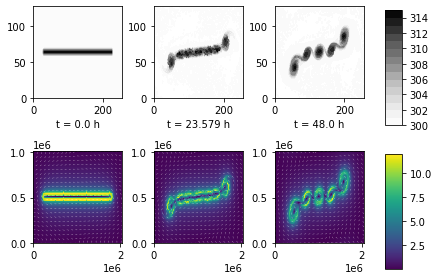

In [11]:

#Path management
from pathlib import Path
import os
import inspect
self_path = Path(os.path.dirname(inspect.getfile(lambda: None)))


#Custom functions
from test_cases import bubble_test, gaussian_test, v_stripe_test
from advection_driver import advection_driver
from ugly_plot import ugly_plot

# Pick an adress for the netCDF file (it will over write existing files)
path = self_path / "out.nc" 

# Parameters
Lx = 2048E3
Ly = 1024E3
Nx = 256
Ny = 128

# Nt will drive the computation time. On my standard laptop (when plugged in), 
# I measure around 500 time cycles per hour for linear interpolation.
dt = 3000
T = 48*3600
Nt = int(T//dt)



# Pick a test case

# Half width of the stripe
dY = Ny//20
# Distance between the side of the X axis and the first V-profile
dX = Nx//8
v_stripe_test(path, Lx, Ly, Nx, Ny, T, Nt, dX, dY)

# cx = Lx//2
# cy = Ly//2
# radius = Lx/20
# bubble_test(path, Lx, Ly, Nx, Ny, T, Nt, cx, cy, radius)


# # The advection driver will propagate the solution in time
advection_driver(path, pseudo_spectral_wind = 1,
                 alpha_method = 'linear', F_method='linear')

# the name is accurate, it is a plot, it is ugly
ugly_plot(path, ratio=20, lvl_num=15)

The plots look like the value of the background is shifting from zero but it actually comes from the fact that small negative values appear at the border of the bubble and shift the colormap. These values come from the cubic interpolation which can reach values lower than the minimum/larger than the maximum around discontinuities or large changes in general. If you shift to linear interpolation, this issue disappears, but cubic interpolation is recommended in the article. I suspect this issue will be less important with continuous initial conditions. 